In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread('/home/harish/Documents/Python Scripts/IVP Lab/Assignment4/Haze.jpg')

In [3]:
def local_color_correction(image):
    B = image[:,:,0]
    G = image[:,:,1]
    R = image[:,:,2]
    
    fft_B = np.fft.fft2(B)
    fft_G = np.fft.fft2(G)
    fft_R = np.fft.fft2(R)
    
    M = len(B)
    N = len(B[0])
    
    sigma=2
    Nr = np.fft.ifftshift((range(int(-np.floor(M/2)),int(np.ceil(M/2)))))
    Nc = np.fft.ifftshift((range(int(-np.floor(N/2)),int(np.ceil(N/2)))))
    
    Nc,Nr = np.meshgrid(Nc,Nr)
    
    dft_gauss_kernel = np.exp(-2*(sigma*np.pi)*(sigma*np.pi)*(np.square(Nr/M)+np.square(Nc/N))) 
    
    fft_B_conv = np.multiply(fft_B,np.tile(dft_gauss_kernel,[1,1]))
    fft_G_conv = np.multiply(fft_G,np.tile(dft_gauss_kernel,[1,1]))
    fft_R_conv = np.multiply(fft_R,np.tile(dft_gauss_kernel,[1,1]))
    
    MB = np.real(np.fft.ifft2(fft_B_conv))
    MG = np.real(np.fft.ifft2(fft_G_conv))
    MR = np.real(np.fft.ifft2(fft_R_conv))
    
    out = np.zeros(np.shape(image))
    
    out[:,:,0] = np.power(B,2**(2*MB-1))
    out[:,:,1] = np.power(G,2**(2*MG-1))
    out[:,:,2] = np.power(R,2**(2*MR-1))
    
    return out

color corrected


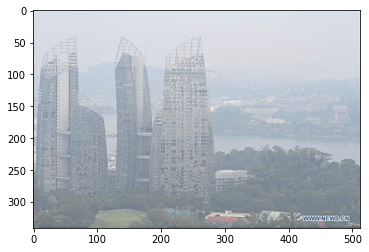

original


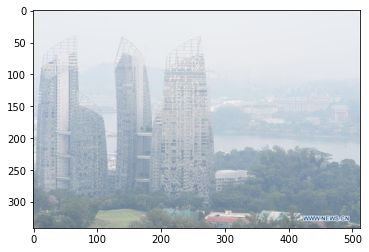

In [4]:
print("color corrected")
plt.imshow(np.flip(local_color_correction(image/255),axis = 2))
plt.show()
print("original")
plt.imshow(np.flip(image,axis = 2))
plt.show()

In [5]:
def SimpleColorBalance(image,percent):
    B = image[:,:,0]
    G = image[:,:,1]
    R = image[:,:,2]
    
    B_sort = np.sort(B.flatten())
    B_min = B_sort[int(percent*0.005*len(B_sort))]
    B_max = B_sort[int((1-percent*0.005)*len(B_sort))-1]
    
    G_sort = np.sort(G.flatten())
    G_min = G_sort[int(percent*0.005*len(G_sort))]
    G_max = G_sort[int((1-percent*0.005)*len(G_sort))-1]
    
    R_sort = np.sort(R.flatten())
    R_min = R_sort[int(percent*0.005*len(R_sort))]
    R_max = R_sort[int((1-percent*0.005)*len(R_sort))-1]
    
    B_clipped = (B < B_min)*B_min + (B >= B_min)*(B <= B_max)*B + (B > B_max)*B_max
    G_clipped = (G < G_min)*G_min + (G >= G_min)*(G <= G_max)*G + (G > G_max)*G_max
    R_clipped = (R < R_min)*R_min + (R >= R_min)*(R <= R_max)*R + (R > R_max)*R_max
    
    B_out = (B_clipped-B_min)*1./(B_max-B_min)
    G_out = (G_clipped-G_min)*1./(G_max-G_min)
    R_out = (R_clipped-R_min)*1./(R_max-R_min)
    
    output = np.zeros(np.shape(image))
    
    output[:,:,0] = B_out
    output[:,:,1] = G_out
    output[:,:,2] = R_out
    
    return output

simple color balanced


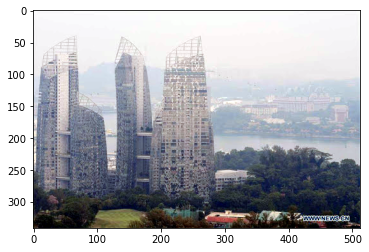

original


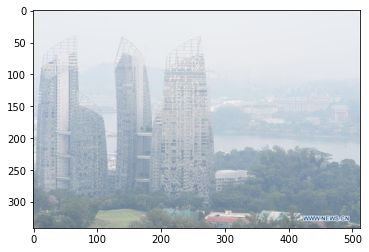

In [6]:
print("simple color balanced")
plt.imshow(np.flip(SimpleColorBalance(image,2),axis = 2))
plt.show()
print("original")
plt.imshow(np.flip(image,axis = 2))
plt.show()

In [7]:
def poisson(image,s,l):
    
    saturated = SimpleColorBalance(image,s)
    
    img_len = len(image)
    img_wid = len(image[0])
    
    periodic = np.zeros((2*img_len,2*img_wid,3))
    periodic[:img_len,:img_wid] = saturated
    periodic[img_len:2*img_len,:img_wid] = np.flip(saturated,axis = 0)
    periodic[:img_len,img_wid:2*img_wid] = np.flip(saturated,axis = 1)
    periodic[img_len:2*img_len,img_wid:2*img_wid] = np.flip(np.flip(saturated,axis = 0),axis = 1)
    
    B_fft = np.fft.fft2(periodic[:,:,0])
    G_fft = np.fft.fft2(periodic[:,:,1])
    R_fft = np.fft.fft2(periodic[:,:,2])
    
    uB_fft = np.zeros(np.shape(B_fft),dtype = "complex")
    uG_fft = np.zeros(np.shape(G_fft),dtype = "complex")
    uR_fft = np.zeros(np.shape(R_fft),dtype = "complex")
    
    for i in range(2*img_len):
        for j in range(2*img_wid):
            uB_fft[i,j] = (((np.pi*i/(2*img_len))**2 + (np.pi*j/(2*img_wid))**2)/(l+((np.pi*i/(2*img_len))**2 + (np.pi*j/(2*img_wid))**2)))*B_fft[i,j]
            uG_fft[i,j] = (((np.pi*i/(2*img_len))**2 + (np.pi*j/(2*img_wid))**2)/(l+((np.pi*i/(2*img_len))**2 + (np.pi*j/(2*img_wid))**2)))*G_fft[i,j]
            uR_fft[i,j] = (((np.pi*i/(2*img_len))**2 + (np.pi*j/(2*img_wid))**2)/(l+((np.pi*i/(2*img_len))**2 + (np.pi*j/(2*img_wid))**2)))*R_fft[i,j]
    
    u_B = np.real(np.fft.ifft2(uB_fft))
    u_G = np.real(np.fft.ifft2(uG_fft))
    u_R = np.real(np.fft.ifft2(uR_fft))
    
    output = SimpleColorBalance(cv2.merge((u_B,u_G,u_R))[:img_len,:img_wid],s)
    
    return output
    

poisson


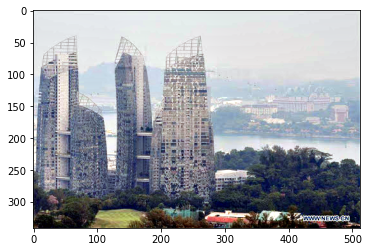

original


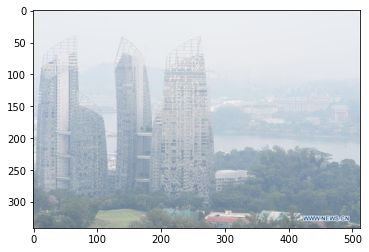

In [8]:
print("poisson")
plt.imshow(np.flip(poisson(image,2,0.0001),axis = 2))
plt.show()
print("original")
plt.imshow(np.flip(image,axis = 2))
plt.show()